In [1]:
import pandas_datareader as data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, InputLayer,
                                     Conv1D, MaxPool1D,
                                     Reshape,
                                     LSTM, GRU)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

**Data (intra-day)**

In [3]:
intraday_data = yf.download(tickers="MSFT",
                            period="2y",
                            interval="1h",
                            auto_adjust=True)
intraday_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2020-08-12 11:30:00-04:00,208.940002,209.830002,208.669998,209.710007,0
2020-08-12 12:30:00-04:00,209.720001,209.750000,208.610001,208.729996,2247748
2020-08-12 13:30:00-04:00,208.729996,210.279999,208.580002,209.952606,2930137
2020-08-12 14:30:00-04:00,209.949997,210.100006,209.089996,209.514999,2766915
2020-08-12 15:30:00-04:00,209.529999,209.639999,208.619995,209.289993,3037786


**Microsoft close prices**

In [4]:
pd.options.plotting.backend = "plotly"
intraday_data.plot(y=['Open'])

In [5]:
sequence_opens = intraday_data.values[: , 0]
sequence_opens.shape

(3521,)

**Split and flip data randomly**

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# choose a number of time steps
n_steps = 7
# split into samples
X, y = split_sequence(sequence_opens, n_steps)

In [8]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)
n_train = int(0.8*X.shape[0])
n_val = int(0.9*X.shape[0])
X_train, y_train = X[:n_train, :], y[:n_train]
X_val, y_val = X[n_train:n_val, :], y[n_train:n_val]
X_test, y_test = X[n_val:, :], y[n_val:]

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

### Linear model


In [10]:
model = Sequential()

model.add(Flatten())

model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


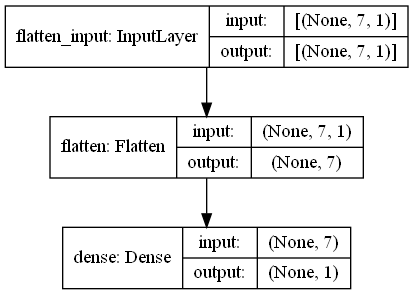

In [11]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

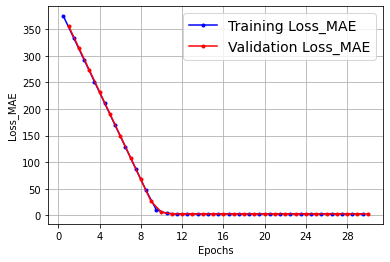

In [12]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

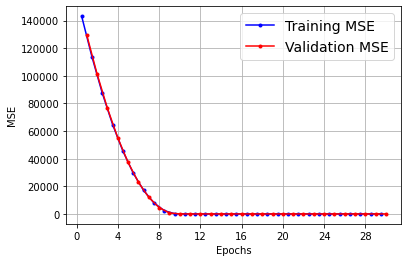

In [13]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 800us/step


Text(0, 0.5, 'Test Values')

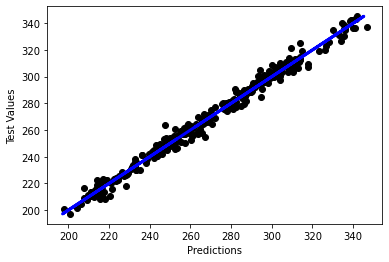

In [14]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Deep Neural Network

In [15]:
dnn_hidden_units = [16, 8]

model = Sequential()
for layer in dnn_hidden_units:
    model.add(Dense(units=layer,
                    activation="relu"))

model.add(Flatten())


model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7, 16)             32        
_________________________________________________________________
dense_2 (Dense)              (None, 7, 8)              136       
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 57        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


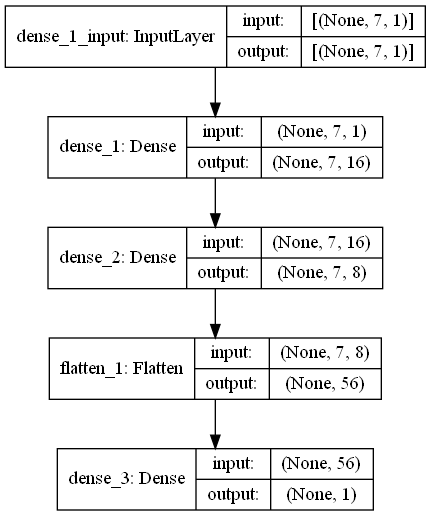

In [16]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

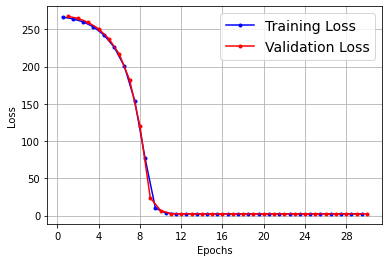

In [17]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

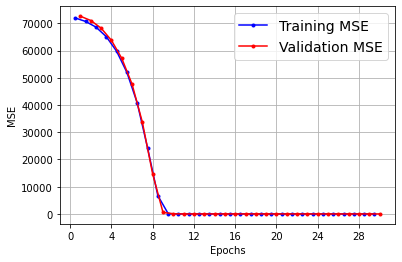

In [18]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 800us/step


Text(0, 0.5, 'Test Values')

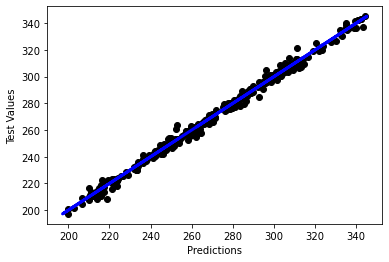

In [19]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Last Model (Temporal Convolutional Network with Dilation and causal convolution)


In [20]:
model = Sequential()
model.add(InputLayer(input_shape=[n_steps, 1]))
for dilation_rate in (1, 2, 4):
    model.add(
      Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(Conv1D(filters=64, kernel_size=1))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 64)             2112      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

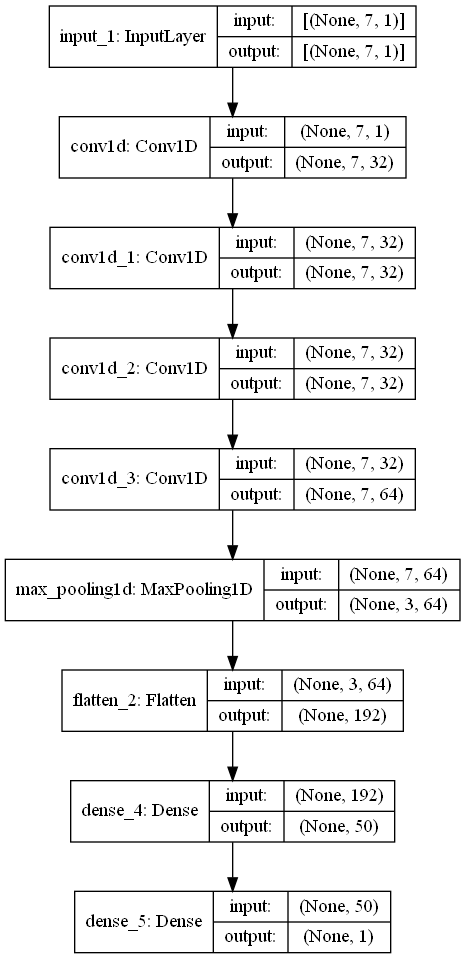

In [21]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=0)

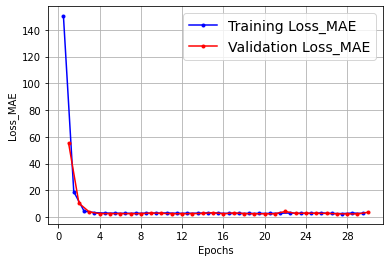

In [23]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

In [24]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 0s 1ms/step - loss: 3.6184 - mse: 19.9176
test loss, test acc: [3.618391275405884, 19.917646408081055]


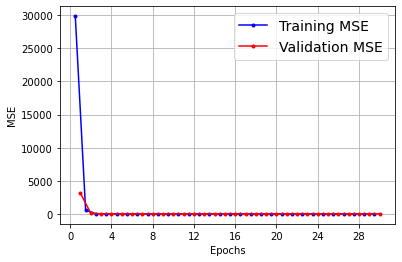

In [25]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

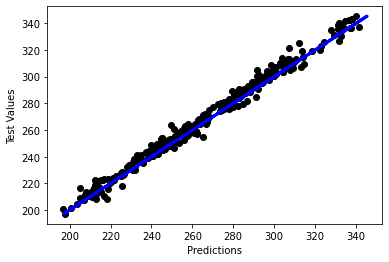

In [26]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Recurrent Neural Network


In [27]:
model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[n_steps, 1]))
model.add(LSTM(n_steps // 2,
               activation='relu',
               return_sequences=False))

model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

# Create the model.
model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    epochs=40,
                    verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 7, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


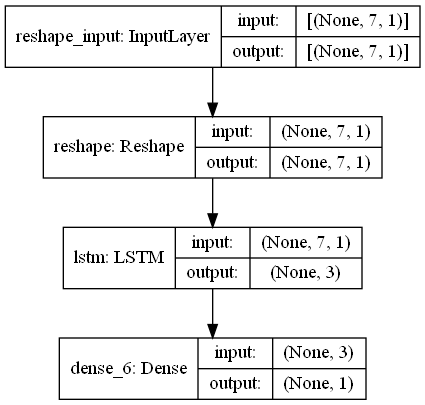

In [28]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

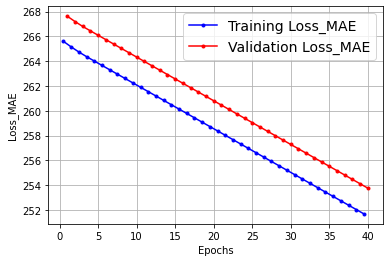

In [29]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

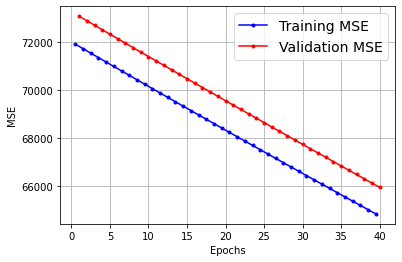

In [30]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

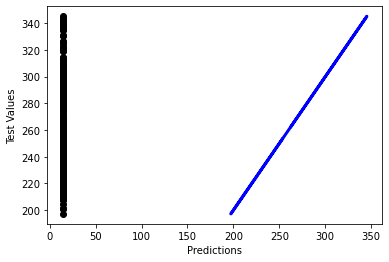

In [31]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Multi-layer RNN


In [32]:
rnn_hidden_units = [n_steps // 2,
                    n_steps // 4]

model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[n_steps, 1]))

for layer in rnn_hidden_units[:-1]:
    model.add(GRU(units=layer,
                  activation='relu',
                  return_sequences=True))

model.add(GRU(units=rnn_hidden_units[-1],
              return_sequences=False))


model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 7, 1)              0         
_________________________________________________________________
gru (GRU)                    (None, 7, 3)              54        
_________________________________________________________________
gru_1 (GRU)                  (None, 1)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


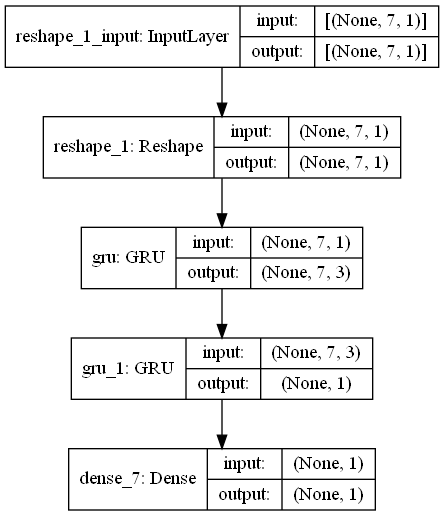

In [33]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

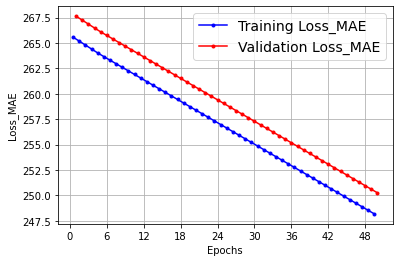

In [34]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

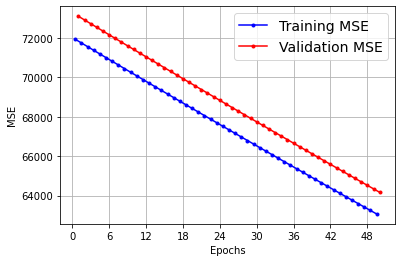

In [35]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Test Values')

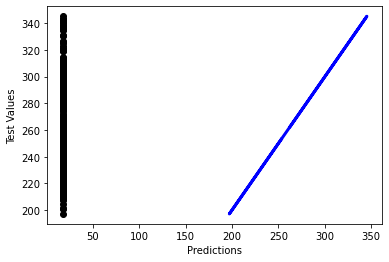

In [36]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")